# AI Security II - Final Project
## A Black-Box Adversarial Attack Strategy with Model Stealing
**Department of Cyber Defense, Korea University**

**Student ID: 2021350226**

**Name: Hyomin Lee**



### 1. Hypothesis

This project explores the intersection of adversarial attacks and model stealing techniques within the realm of AI security. Adversarial attacks, such as Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD), are designed to subtly modify input data in a way that leads machine learning models to make incorrect predictions. These methods have shown effectiveness in various scenarios, highlighting the vulnerability of AI systems to such manipulations.

Model Stealing Attacks, particularly the KnockoffNets framework, represent a different vector of threat. They involve creating a surrogate model that approximates the functionality of a target model by training on data synthesized from the target. This approach is particularly relevant in scenarios where direct access to the target model's data or architecture is restricted.

The central hypothesis of this project is that a synergistic combination of these two attack vectors – a black-box adversarial attack strategy leveraging model stealing – can be particularly effective. By first stealing a model and then generating adversarial examples based on this stolen model, I propose that these adversarial examples could still effectively compromise the original model. This hypothesis is rooted in the assumption that the stolen model, while not an exact replica, captures enough of the original model's decision boundaries to create effective adversarial examples.

The experimental focus will be on determining whether adversarial examples crafted using a stolen model (via methods like KnockoffNets) maintain their efficacy when applied to the original model. If proven true, this could indicate a significant vulnerability in AI systems, where an attacker does not need direct access or complete knowledge of a target model to compromise its integrity effectively.

### 2. Method

**2-1. Adversarial Attack Methods**

- **FGSM**: This method involves applying a small perturbation to the input data, determined by the gradient of the loss with respect to the input data. The perturbation is designed to maximize the loss, leading to misclassification by the model.

- **PGD**: This is an iterative version of the FGSM. It applies multiple small perturbations, recalculating the gradient after each step. This method is more powerful than FGSM and is widely used to test the robustness of neural networks.


**2-2. Model Stealing Attack Methods**

- **KnockoffNets**: KnockoffNets is a model stealing attack method, particularly effective against black-box models where the attacker has limited information about the model's internal workings. It involves querying the target model with input data, collecting its predictions, and using these input-output pairs to create a synthetic dataset. This dataset is then used to train a knockoff model, designed to mimic the target model's behavior. The significance of KnockoffNets lies in its ability to approximate a target model's decision-making process without requiring access to its training data, architecture, or parameters, highlighting vulnerabilities in AI systems that rely on parameter secrecy for security.

**2-3. Black-Box Adversarial Attack Strategy**

1. **Model Stealing**: First, implement the KnockoffNets attack to create a surrogate of the target model.
2. **Adversarial Example Generation**: Using the stolen model, generate adversarial examples using both FGSM and PGD methods.
3. **Effectiveness Testing**: Test these adversarial examples on the original target model to assess the effectiveness of the attack. The key metric will be the misclassification rate induced by these examples on the target model.

**2-4. Evaluation Metrics**

- **Transferability Rate**: Measure how many adversarial examples generated from the knockoff model are effective against the victim model. This metric directly assesses the core hypothesis - the efficacy of adversarial examples crafted from a stolen model.

### 3. Experiment Settings

**3-1. Victim Model**
- **Model Architecture**: ResNet-18
- **Dataset**: CIFAR-10
The victim model, built on the ResNet-18 architecture, is trained on the CIFAR-10 dataset. This dataset comprises 60,000 32x32 color images in 10 classes, with 6,000 images per class, providing a diverse range of inputs for testing the model's robustness against adversarial attacks.

**3-2. Attacker's Capabilities and Assumptions**
- **Knowledge Limitation**: It is assumed that the attacker does not have prior knowledge of the victim model's architecture (ResNet-18) or the specific dataset (CIFAR-10) it has been trained on.
- **Attacker's Models**: For the purpose of model stealing and generating adversarial examples, two architectures will be utilized: ResNet-18(random init) and AlexNet. This choice allows for a comparison between using a similar architecture to the victim's model (ResNet-18) and a different one (AlexNet).
- **Datasets**: The attacker will use a mix of CIFAR-10 and MNIST datasets for training the knockoff models. MNIST is a large database of handwritten digits that is widely used for training various image processing systems. The combination of CIFAR-10 and MNIST provides a varied and comprehensive set of data for training the knockoff models, ensuring they learn a wide range of features.

**3-3. Testing Environment**
- Processor: Intel Core i7-12700KF
- Graphics Card: NVIDIA RTX 3080 (10GB VRAM)

### 4. Experiment Results (+ code) & Analysis

- **4-1. module import & dataloader** 

To conduct a Model Stealing Attack, the attacker will load the MNIST and CIFAR-10 datasets. Since the attacker is unaware of the specific dataset used by the Victim Model for training, multiple datasets will be concatenated to proceed with the attack.

In [330]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import detectors
import time
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import random
import numpy as np

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [331]:
#prepare dataset and preprocessing
mnist_transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [332]:
# Load dataset
BATCH_SIZE = 50

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform_train)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar10_transform_train)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar10_transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=1000, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [333]:
# Define the classes for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

- Victim model(pretained) baseline accuracy

In [334]:
def victim_test():
    model_victim = timm.create_model("resnet18_cifar10", pretrained=True)
    model_victim.to(device)

    acc, tot = 0.0, 0.0
    model_victim.eval()
    with torch.no_grad():
        for data in cifar10_testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            y_predict = model_victim(images)

            _, predicted = torch.max(y_predict.data, 1)
            tot += labels.size(0)
            acc += (predicted == labels).sum().item()

    return 100. * acc / tot

In [335]:
victim_accuracy = victim_test()
print(victim_accuracy)

94.98


- **4-2. Model Stealing Attack**


In this part of the experiment, I will conduct the Knockoffnet attack using two architectural approaches.

Initially, I will use an Attacker model with the same architecture as the Victim Model, ResNet-18, but with differing parameters. This is to assess the impact of model stealing when the architectures of the attacker and victim models are similar.

Subsequently, I will utilize AlexNet, an architecture that is significantly different from the Victim Model, as another Attacker model. This will help in understanding the effectiveness of model stealing when there is a substantial architectural divergence.

The analysis will then focus on determining which architectural approach - similar or different from the Victim Model - is more effective in Black-box Adversarial Attacks.

In [336]:
#set hyperparameter
LR = 0.08
weight_decay = 0.0005
momentum = 0.8
nesterov=True
epochs = 5

In [337]:
criterion = nn.CrossEntropyLoss()

In [338]:
combined_dataset = ConcatDataset([mnist_trainset, cifar10_trainset])
# DataLoader
cifar10_mnist_trainloader = torch.utils.data.DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

- resnet18 knockoffnet attack

In [339]:
stolen_resnet18_model = timm.create_model("resnet18_cifar10", pretrained=False)
stolen_resnet18_model.to(device)

def resnet18_knockoffnet():
    model_victim = timm.create_model("resnet18_cifar10", pretrained=True)
    model_victim.to(device)

    optimizer = optim.SGD(stolen_resnet18_model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)

    tot_queries = 0
    accuracies = []
    queries = []

    stolen_resnet18_model.train()
    for epoch in range(epochs):
        for data in cifar10_mnist_trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            tot_queries += len(images)

            y_target = model_victim(images).detach()

            y_target = F.softmax(y_target, dim=1)

            optimizer.zero_grad()

            # forward & backward
            y_predict = stolen_resnet18_model(images)
            loss = criterion(y_predict, y_target)
            loss.backward()
            optimizer.step()

            # check accuracy and print tot_queries
            if tot_queries % 50000 == 0:
                acc, tot = 0.0, 0.0
                stolen_resnet18_model.eval()
                with torch.no_grad():
                    for data in cifar10_testloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)

                        y_predict = stolen_resnet18_model(images)

                        _, predicted = torch.max(y_predict.data, 1)
                        tot += labels.size(0)
                        acc += (predicted == labels).sum().item()

                    print(f"test accuracy of knockoff net: {acc}/{tot} ({100*acc/tot}%)")
                    accuracies.append(100*acc/tot)
                    queries.append(tot_queries/1000)
                stolen_resnet18_model.train()

            print(f"epoch: {epoch}, loss: {loss.item()}, tot_queries: {tot_queries}....")

    print(f"done training.")
    print(accuracies, queries)

    return accuracies, queries

In [340]:
resnet18_knockoffnet_result = resnet18_knockoffnet()

epoch: 0, loss: 2.3877251148223877, tot_queries: 50....
epoch: 0, loss: 2.368889570236206, tot_queries: 100....
epoch: 0, loss: 2.23118257522583, tot_queries: 150....
epoch: 0, loss: 2.1901657581329346, tot_queries: 200....
epoch: 0, loss: 2.2283592224121094, tot_queries: 250....
epoch: 0, loss: 2.271022319793701, tot_queries: 300....
epoch: 0, loss: 2.1304335594177246, tot_queries: 350....
epoch: 0, loss: 2.1321794986724854, tot_queries: 400....
epoch: 0, loss: 2.1534318923950195, tot_queries: 450....
epoch: 0, loss: 2.1486287117004395, tot_queries: 500....
epoch: 0, loss: 2.284318208694458, tot_queries: 550....
epoch: 0, loss: 2.0656635761260986, tot_queries: 600....
epoch: 0, loss: 2.074204444885254, tot_queries: 650....
epoch: 0, loss: 2.289608955383301, tot_queries: 700....
epoch: 0, loss: 1.9921789169311523, tot_queries: 750....
epoch: 0, loss: 2.0899136066436768, tot_queries: 800....
epoch: 0, loss: 2.0623490810394287, tot_queries: 850....
epoch: 0, loss: 2.3380072116851807, tot

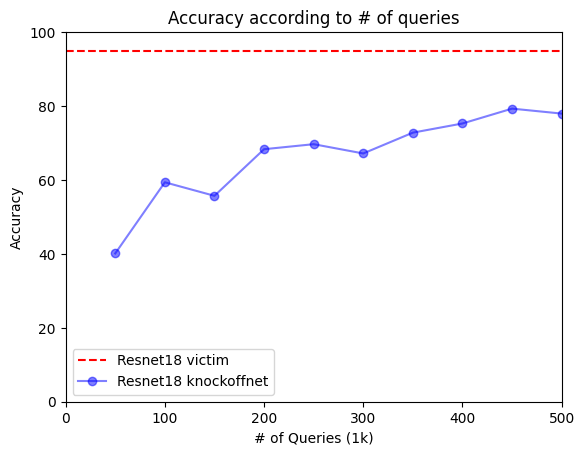

In [341]:
plt.axhline(y=victim_accuracy, xmin=0, xmax=500, color='red', linestyle='--', label="Resnet18 victim") #baseline
plt.plot(resnet18_knockoffnet_result[1], resnet18_knockoffnet_result[0], color='blue', marker='o', alpha=0.5, label='Resnet18 knockoffnet')

plt.legend()
plt.xlabel('# of Queries (1k)')
plt.ylabel('Accuracy')
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.title('Accuracy according to # of queries')
plt.show()


Upon completing the Knockoffnet attack with up to 500,000 queries, I have successfully developed a Stolen model that achieves approximately 78% of the performance level of the original model.

In [342]:
print(f"Stolen model accuracy: {resnet18_knockoffnet_result[0][-1]}%")

Stolen model accuracy: 78.64%


- AlexNet knockoffnet attack

In [343]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3), nn.ReLU(), 
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 1), nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*3*3, 1024), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024,512), nn.ReLU(),
            nn.Linear(512,10))
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*3*3)
        x = self.classifier(x)
        return x

In [344]:
stolen_alexnet_model = AlexNet()
stolen_alexnet_model.to(device)

def alexnet_knockoffnet():
    model_victim = timm.create_model("resnet18_cifar10", pretrained=True)
    model_victim.to(device)

    optimizer = optim.SGD(stolen_alexnet_model.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)

    tot_queries = 0
    accuracies = []
    queries = []

    stolen_alexnet_model.train()
    for epoch in range(epochs):
        for data in cifar10_mnist_trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            tot_queries += len(images)

            y_target = model_victim(images).detach()

            y_target = F.softmax(y_target, dim=1)

            optimizer.zero_grad()

            # forward & backward
            y_predict = stolen_alexnet_model(images)
            loss = criterion(y_predict, y_target)
            loss.backward()
            optimizer.step()

            # check accuracy and print tot_queries
            if tot_queries % 50000 == 0:
                acc, tot = 0.0, 0.0
                stolen_alexnet_model.eval()
                with torch.no_grad():
                    for data in cifar10_testloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)

                        y_predict = stolen_alexnet_model(images)

                        _, predicted = torch.max(y_predict.data, 1)
                        tot += labels.size(0)
                        acc += (predicted == labels).sum().item()

                    print(f"test accuracy of knockoff net: {acc}/{tot} ({100*acc/tot}%)")
                    accuracies.append(100*acc/tot)
                    queries.append(tot_queries/1000)
                stolen_alexnet_model.train()

            print(f"epoch: {epoch}, loss: {loss.item()}, tot_queries: {tot_queries}....")

    print(f"done training.")
    print(accuracies, queries)

    return accuracies, queries

In [345]:
alexnet_knockoffnet_result = alexnet_knockoffnet()

epoch: 0, loss: 2.301713228225708, tot_queries: 50....
epoch: 0, loss: 2.2942843437194824, tot_queries: 100....
epoch: 0, loss: 2.294400691986084, tot_queries: 150....
epoch: 0, loss: 2.291449785232544, tot_queries: 200....
epoch: 0, loss: 2.2944936752319336, tot_queries: 250....
epoch: 0, loss: 2.2830896377563477, tot_queries: 300....
epoch: 0, loss: 2.2703583240509033, tot_queries: 350....
epoch: 0, loss: 2.291210889816284, tot_queries: 400....
epoch: 0, loss: 2.2766568660736084, tot_queries: 450....
epoch: 0, loss: 2.2777700424194336, tot_queries: 500....
epoch: 0, loss: 2.2819955348968506, tot_queries: 550....
epoch: 0, loss: 2.2543656826019287, tot_queries: 600....
epoch: 0, loss: 2.279144048690796, tot_queries: 650....
epoch: 0, loss: 2.261226177215576, tot_queries: 700....
epoch: 0, loss: 2.246262311935425, tot_queries: 750....
epoch: 0, loss: 2.2399566173553467, tot_queries: 800....
epoch: 0, loss: 2.2069814205169678, tot_queries: 850....
epoch: 0, loss: 2.242450714111328, tot_

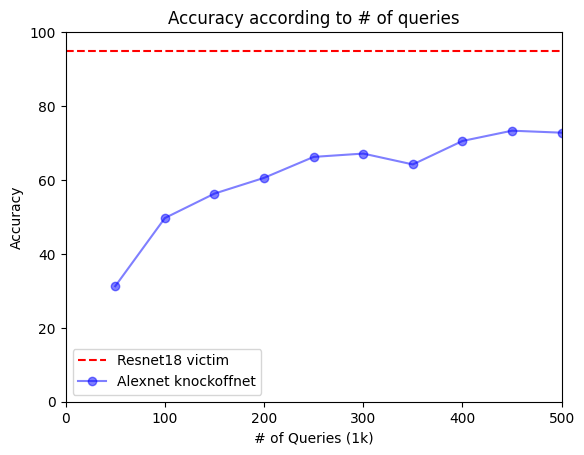

In [346]:
plt.axhline(y=victim_accuracy, xmin=0, xmax=500, color='red', linestyle='--', label="Resnet18 victim") #baseline
plt.plot(alexnet_knockoffnet_result[1], alexnet_knockoffnet_result[0], color='blue', marker='o', alpha=0.5, label='Alexnet knockoffnet')

plt.legend()
plt.xlabel('# of Queries (1k)')
plt.ylabel('Accuracy')
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.title('Accuracy according to # of queries')
plt.show()


Utilizing the AlexNet architecture, I have also successfully created a Stolen model 2 that achieved approximately 70% accuracy.

In [397]:
print(alexnet_knockoffnet_result[0][-1])

70.82


- **4-3. Adversarial Example Generation**

Adversarial examples will be generated for the given models. This will be accomplished using two methods: the Fast Gradient Sign Method (FGSM) and the Projected Gradient Descent (PGD).

In [347]:
epsilons = [0, .01, .03, .05, .07, .09, .11]

In [348]:
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=1, shuffle=False, num_workers=2)

In [349]:
def untargeted_fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -3, 3)
    return perturbed_image

In [350]:
def untargeted_fgsm_test(model, device, test_loader, epsilon):
    # Initialize counters and lists
    correct = 0
    adv_examples = []

    model.eval()
    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data

        perturbed_data = untargeted_fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
        else:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    

    final_acc = correct / float(len(test_loader))
    print("[Untargeted FGSM]\nEpsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [351]:
def untargeted_pgd_attack(image, alpha, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    adv_image = image + alpha * sign_data_grad

    e = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
    update_image = torch.clamp(image + e, -3, 3)

    return update_image

In [ ]:
def untargeted_pgd_test(model, device, test_loader, alpha, epsilon):
    correct = 0
    adv_examples = []

    model.eval()
    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        update_image = None
        for iter in range(3):
            if update_image != None:
                output = model(update_image)

            loss = criterion(output, target)
            model.zero_grad()
            loss.backward()

            data_grad = data.grad.data

            update_image = untargeted_pgd_attack(data, alpha, epsilon, data_grad)
            
        output = model(update_image)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
        else:
            adv_ex = update_image.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    

    final_acc = correct / float(len(test_loader))
    print("[Untargeted PGD]\nEpsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

Adversarial examples will be created for the stolen ResNet-18 model using the Fast Gradient Sign Method (FGSM). The experiment will display a proportional decrease in accuracy corresponding to the values of epsilon.

In [353]:
untargeted_fgsm_accuracies1 = []
untargeted_fgsm_examples1 = []

for eps in epsilons:
    untargeted_fgsm_accuracy, untargeted_fgsm_example = untargeted_fgsm_test(stolen_resnet18_model, device, cifar10_testloader, eps)

    untargeted_fgsm_accuracies1.append(untargeted_fgsm_accuracy)
    untargeted_fgsm_examples1.append(untargeted_fgsm_example)

[Untargeted FGSM]
Epsilon: 0	Test Accuracy = 7864 / 10000 = 0.7864
[Untargeted FGSM]
Epsilon: 0.01	Test Accuracy = 5962 / 10000 = 0.5962
[Untargeted FGSM]
Epsilon: 0.03	Test Accuracy = 2860 / 10000 = 0.286
[Untargeted FGSM]
Epsilon: 0.05	Test Accuracy = 1360 / 10000 = 0.136
[Untargeted FGSM]
Epsilon: 0.07	Test Accuracy = 754 / 10000 = 0.0754
[Untargeted FGSM]
Epsilon: 0.09	Test Accuracy = 508 / 10000 = 0.0508
[Untargeted FGSM]
Epsilon: 0.11	Test Accuracy = 380 / 10000 = 0.038


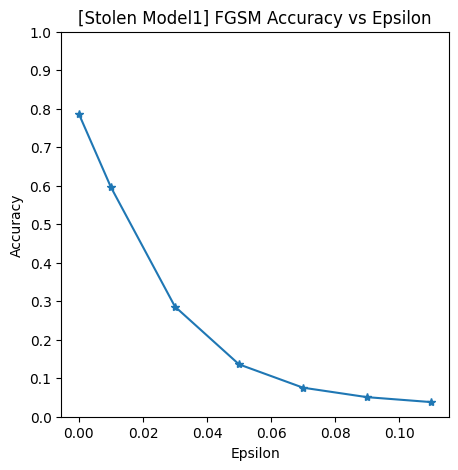

In [356]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, untargeted_fgsm_accuracies1, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Stolen Model1] FGSM Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


Adversarial examples for the stolen ResNet-18 model will be generated using the Projected Gradient Descent (PGD) method.

In [365]:
untargeted_pgd_accuracies1 = []
untargeted_pgd_examples1 = []

for eps in epsilons:
    untargeted_pgd_accuracy, untargeted_pgd_example = untargeted_pgd_test(stolen_resnet18_model, device, cifar10_testloader, 0.1, eps)

    untargeted_pgd_accuracies1.append(untargeted_pgd_accuracy)
    untargeted_pgd_examples1.append(untargeted_pgd_example)

[Untargeted PGD]
Epsilon: 0	Test Accuracy = 7864 / 10000 = 0.7864
[Untargeted PGD]
Epsilon: 0.01	Test Accuracy = 5799 / 10000 = 0.5799
[Untargeted PGD]
Epsilon: 0.03	Test Accuracy = 1994 / 10000 = 0.1994
[Untargeted PGD]
Epsilon: 0.05	Test Accuracy = 533 / 10000 = 0.0533
[Untargeted PGD]
Epsilon: 0.07	Test Accuracy = 176 / 10000 = 0.0176
[Untargeted PGD]
Epsilon: 0.09	Test Accuracy = 97 / 10000 = 0.0097
[Untargeted PGD]
Epsilon: 0.11	Test Accuracy = 88 / 10000 = 0.0088


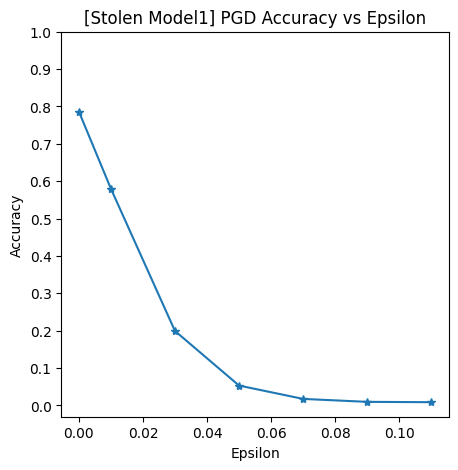

In [366]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, untargeted_pgd_accuracies1, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Stolen Model1] PGD Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

For the AlexNet model, adversarial examples will be generated by executing the Fast Gradient Sign Method (FGSM).

In [367]:
untargeted_fgsm_accuracies2 = []
untargeted_fgsm_examples2 = []

for eps in epsilons:
    untargeted_fgsm_accuracy, untargeted_fgsm_example = untargeted_fgsm_test(stolen_alexnet_model, device, cifar10_testloader, eps)

    untargeted_fgsm_accuracies2.append(untargeted_fgsm_accuracy)
    untargeted_fgsm_examples2.append(untargeted_fgsm_example)

[Untargeted FGSM]
Epsilon: 0	Test Accuracy = 7082 / 10000 = 0.7082
[Untargeted FGSM]
Epsilon: 0.01	Test Accuracy = 6234 / 10000 = 0.6234
[Untargeted FGSM]
Epsilon: 0.03	Test Accuracy = 4739 / 10000 = 0.4739
[Untargeted FGSM]
Epsilon: 0.05	Test Accuracy = 3636 / 10000 = 0.3636
[Untargeted FGSM]
Epsilon: 0.07	Test Accuracy = 2828 / 10000 = 0.2828
[Untargeted FGSM]
Epsilon: 0.09	Test Accuracy = 2168 / 10000 = 0.2168
[Untargeted FGSM]
Epsilon: 0.11	Test Accuracy = 1697 / 10000 = 0.1697


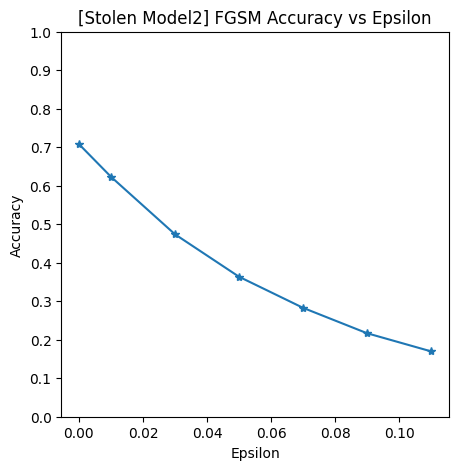

In [368]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, untargeted_fgsm_accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Stolen Model2] FGSM Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Adversarial examples will also be generated for the AlexNet model using the Projected Gradient Descent (PGD) method.

In [369]:
untargeted_pgd_accuracies2 = []
untargeted_pgd_examples2 = []

for eps in epsilons:
    untargeted_pgd_accuracy, untargeted_pgd_example = untargeted_pgd_test(stolen_alexnet_model, device, cifar10_testloader, 0.1, eps)

    untargeted_pgd_accuracies2.append(untargeted_pgd_accuracy)
    untargeted_pgd_examples2.append(untargeted_pgd_example)

[Untargeted PGD]
Epsilon: 0	Test Accuracy = 7082 / 10000 = 0.7082
[Untargeted PGD]
Epsilon: 0.01	Test Accuracy = 6191 / 10000 = 0.6191
[Untargeted PGD]
Epsilon: 0.03	Test Accuracy = 4416 / 10000 = 0.4416
[Untargeted PGD]
Epsilon: 0.05	Test Accuracy = 3012 / 10000 = 0.3012
[Untargeted PGD]
Epsilon: 0.07	Test Accuracy = 1980 / 10000 = 0.198
[Untargeted PGD]
Epsilon: 0.09	Test Accuracy = 1244 / 10000 = 0.1244
[Untargeted PGD]
Epsilon: 0.11	Test Accuracy = 1000 / 10000 = 0.1


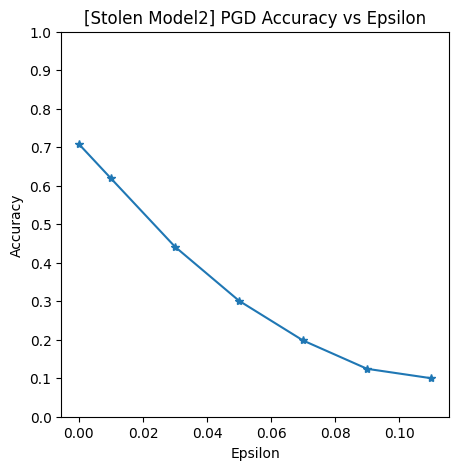

In [370]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, untargeted_pgd_accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Stolen Model2] PGD Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

The results successfully demonstrate the creation of adversarial examples for the stolen models, affirming the effectiveness of both the ResNet-18 and AlexNet architectures in this context. Comparatively, Projected Gradient Descent (PGD) proved to be a more effective attack method than the Fast Gradient Sign Method (FGSM) in terms of reducing accuracy.

- **4-4. Effectiveness Testing**

Now, the experiment will focus on testing the transferability of the adversarial examples generated for the stolen models to the original victim model. This aspect is a crucial component of the Black-box adversarial attack strategy, where the transferability is measured by the success rate of the generated adversarial examples.

In [371]:
def victim_transferability_test(init_preds, final_preds, adv_exs):
    model_victim = timm.create_model("resnet18_cifar10", pretrained=True)
    model_victim.to(device)

    acc, tot = 0.0, 0.0
    model_victim.eval()
    with torch.no_grad():
        for data in zip(adv_exs, init_preds):
            images, labels = data
            images, labels = torch.tensor(images).unsqueeze(0).to(device), torch.tensor(labels).unsqueeze(0).to(device)
            
            y_predict = model_victim(images)

            _, predicted = torch.max(y_predict.data, 1)
            tot += labels.size(0)
            acc += (predicted != labels).sum().item()

    
    return acc / tot

- ResNet-18 FGSM Transferability Rate

In [393]:
transfer_result = [None]
for idx, eps_examples in enumerate(untargeted_fgsm_examples1):

    if eps_examples == []:
        continue
    else:
        init_preds = []
        final_preds = []
        adv_exs = []
        for example in eps_examples:
            init_pred, final_pred, adv_ex = example
            init_preds.append(init_pred)
            final_preds.append(final_pred)
            adv_exs.append(adv_ex)

        transfer_result.append(victim_transferability_test(init_preds, final_preds, adv_exs))

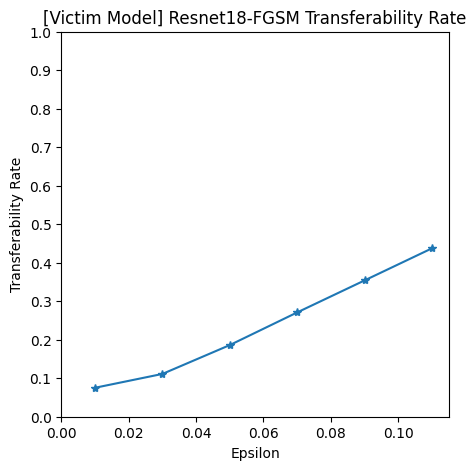

In [394]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, transfer_result, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Victim Model] Resnet18-FGSM Transferability Rate")
plt.xlabel("Epsilon")
plt.ylabel("Transferability Rate")
plt.show()

In [395]:
print(f"Resnet18-FGSM Transferability Rate: {transfer_result[-1]}")

Resnet18-FGSM Transferability Rate: 0.4373329770176376


- ResNet-18 PGD Transferability Rate

In [384]:
transfer_result = [None]
for idx, eps_examples in enumerate(untargeted_pgd_examples1):

    if eps_examples == []:
        continue
    else:
        init_preds = []
        final_preds = []
        adv_exs = []
        for example in eps_examples:
            init_pred, final_pred, adv_ex = example
            init_preds.append(init_pred)
            final_preds.append(final_pred)
            adv_exs.append(adv_ex)

        transfer_result.append(victim_transferability_test(init_preds, final_preds, adv_exs))

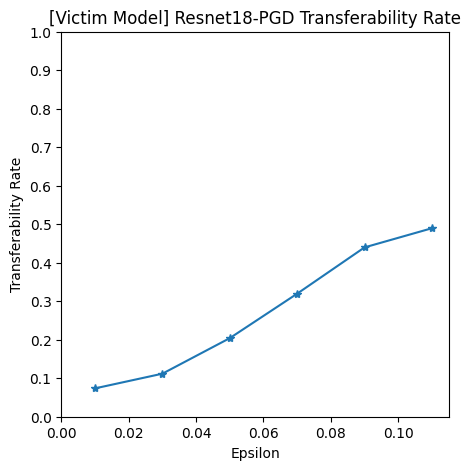

In [385]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, transfer_result, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Victim Model] Resnet18-PGD Transferability Rate")
plt.xlabel("Epsilon")
plt.ylabel("Transferability Rate")
plt.show()

In [386]:
print(f"Resnet18-PGD Transferability Rate: {transfer_result[-1]}")

Resnet18-PGD Transferability Rate: 0.4895833333333333


- AlexNet FGSM Transferability Rate

In [387]:
transfer_result = [None]
for idx, eps_examples in enumerate(untargeted_fgsm_examples2):

    if eps_examples == []:
        continue
    else:
        init_preds = []
        final_preds = []
        adv_exs = []
        for example in eps_examples:
            init_pred, final_pred, adv_ex = example
            init_preds.append(init_pred)
            final_preds.append(final_pred)
            adv_exs.append(adv_ex)

        transfer_result.append(victim_transferability_test(init_preds, final_preds, adv_exs))

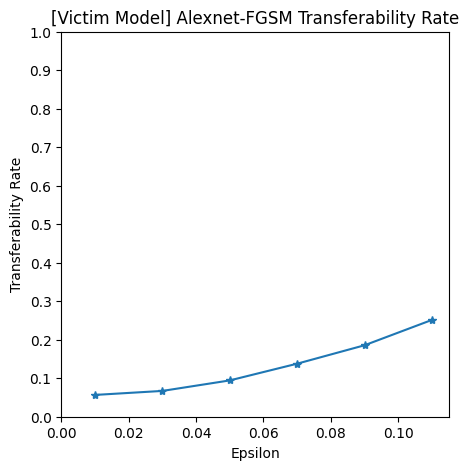

In [388]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, transfer_result, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Victim Model] Alexnet-FGSM Transferability Rate")
plt.xlabel("Epsilon")
plt.ylabel("Transferability Rate")
plt.show()

- AlexNet PGD Transferability Rate

In [389]:
print(f"Alexnet-FGSM Transferability Rate: {transfer_result[-1]}")

Alexnet-FGSM Transferability Rate: 0.25143918291550604


In [390]:
transfer_result = [None]
for idx, eps_examples in enumerate(untargeted_pgd_examples2):

    if eps_examples == []:
        continue
    else:
        init_preds = []
        final_preds = []
        adv_exs = []
        for example in eps_examples:
            init_pred, final_pred, adv_ex = example
            init_preds.append(init_pred)
            final_preds.append(final_pred)
            adv_exs.append(adv_ex)

        transfer_result.append(victim_transferability_test(init_preds, final_preds, adv_exs))

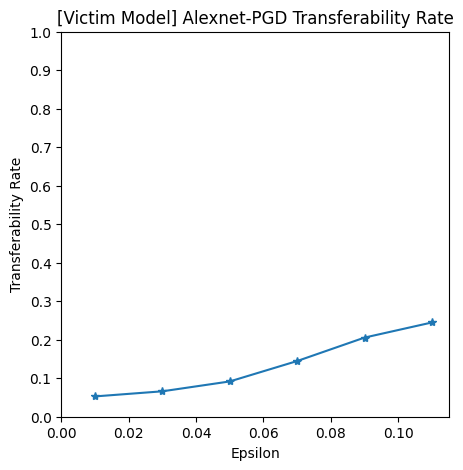

In [391]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, transfer_result, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .12, step=0.02))
plt.title("[Victim Model] Alexnet-PGD Transferability Rate")
plt.xlabel("Epsilon")
plt.ylabel("Transferability Rate")
plt.show()

In [392]:
print(f"Alexnet-PGD Transferability Rate: {transfer_result[-1]}")

Alexnet-PGD Transferability Rate: 0.24482078263729037



Upon examining the Transferability Rate results, it was observed that adversarial examples generated with smaller epsilon values on the stolen models had a lower success rate when applied to the original victim model. However, those created with larger epsilon values demonstrated relatively higher transferability. This suggests that adversarial attacks on stolen models can indeed impact the original victim models, with adversarial examples generated using higher epsilon values showing a greater likelihood of successful attacks on the original victims.

Specifically, adversarial examples created using the ResNet-18 + PGD structure with an epsilon value of 0.11 exhibited nearly half the transferability rate. Significant results were also observed with AlexNet, an architecture different from the victim's. Although the experiments predominantly used smaller epsilon values, it was evident that the transferability of adversarial examples strengthens with increasing epsilon values.

### 5. Discussion

This project revealed that adversarial attacks on stolen models can significantly impact the original victim models.

It demonstrates that even in a black-box scenario, where the attacker lacks knowledge of the victim model's structure or training dataset, theoretically practical and effective adversarial attacks are still feasible.

Moreover, it was measured that adversarial examples generated using PGD generally possess stronger transferability compared to those created with FGSM. Additionally, the increase in epsilon values correlated with more effective attacks on the original victim, as evidenced by the Transferability Rates observed.

This finding underscores the potential for adversarial attacks in scenarios where attackers have limited information about the target models, challenging the security of AI systems even under constrained knowledge conditions.